In [2]:
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score


In [3]:
transform = "log1p"
models = ["ChemBERTa", "MOLE", "Molformer", "SMI-TED289M"]

base_dir = Path("Sample_level_embeddings") / transform

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

results = []


### Loop over models (log1p only)

In [4]:
for model_name in models:
    print(f"\n=== log1p – Model: {model_name} ===")

    path = base_dir / f"{model_name}_sample_embeddings_classification.parquet"
    df = pd.read_parquet(path)

    print("Data shape:", df.shape)

    # Embeddings
    emb_cols = [c for c in df.columns if c.startswith("emb_")]
    X = df[emb_cols].to_numpy(dtype=float)

    # Diagnosis labels
    y_diag = df["Diagnosis"].to_numpy()
    print("X shape:", X.shape)
    print("y shape:", y_diag.shape)
    print("Unique diagnoses:", np.unique(y_diag))

    # ---------- Multiclass (UC / CD / Control) ----------
    le = LabelEncoder()
    y_multi = le.fit_transform(y_diag)
    print("Classes:", le.classes_)

    # ---------- Binary IBD vs Control ----------
    ibd = {"UC", "CD"}
    y_binary = np.array([1 if d in ibd else 0 for d in y_diag], dtype=int)

    # ===================== MLP (same as before) =====================
    clf_multi_mlp = MLPClassifier(
        hidden_layer_sizes=(64,),   # small 1-layer MLP
        activation="relu",
        alpha=1e-3,                 # L2 regularization
        max_iter=2000,
        random_state=0
    )

    clf_bin_mlp = MLPClassifier(
        hidden_layer_sizes=(64,),
        activation="relu",
        alpha=1e-3,
        max_iter=2000,
        random_state=0
    )

    # Multiclass accuracy
    acc_multi_mlp = cross_val_score(
        clf_multi_mlp,
        X,
        y_multi,
        cv=cv,
        scoring="accuracy"
    )

    # Binary AUC
    auc_bin_mlp = cross_val_score(
        clf_bin_mlp,
        X,
        y_binary,
        cv=cv,
        scoring="roc_auc"
    )

    print("MULTICLASS accuracy MLP:", acc_multi_mlp.mean(), "±", acc_multi_mlp.std())
    print("BINARY AUC MLP         :", auc_bin_mlp.mean(),   "±", auc_bin_mlp.std())

    results.append({
        "model": model_name,
        "n_samples": X.shape[0],
        "n_features": X.shape[1],
        "mlp_multiclass_acc_mean": acc_multi_mlp.mean(),
        "mlp_multiclass_acc_std":  acc_multi_mlp.std(),
        "mlp_binary_auc_mean":     auc_bin_mlp.mean(),
        "mlp_binary_auc_std":      auc_bin_mlp.std(),
    })


=== log1p – Model: ChemBERTa ===
Data shape: (220, 770)
X shape: (220, 768)
y shape: (220,)
Unique diagnoses: ['CD' 'Control' 'UC']
Classes: ['CD' 'Control' 'UC']
MULTICLASS accuracy MLP: 0.5954545454545455 ± 0.09022469655126912
BINARY AUC MLP         : 0.8635244490358126 ± 0.03955774201286846

=== log1p – Model: MOLE ===
Data shape: (220, 770)
X shape: (220, 768)
y shape: (220,)
Unique diagnoses: ['CD' 'Control' 'UC']
Classes: ['CD' 'Control' 'UC']
MULTICLASS accuracy MLP: 0.6045454545454546 ± 0.07820295697311479
BINARY AUC MLP         : 0.8555612947658402 ± 0.052560901041259676

=== log1p – Model: Molformer ===
Data shape: (220, 770)
X shape: (220, 768)
y shape: (220,)
Unique diagnoses: ['CD' 'Control' 'UC']
Classes: ['CD' 'Control' 'UC']
MULTICLASS accuracy MLP: 0.6318181818181818 ± 0.1050383637117395
BINARY AUC MLP         : 0.8735321969696969 ± 0.02575236304122556

=== log1p – Model: SMI-TED289M ===
Data shape: (220, 770)
X shape: (220, 768)
y shape: (220,)
Unique diagnoses: ['CD

### Summary table

In [6]:
# -----------------------------
# Nicely formatted summary table
# -----------------------------
tbl = results_log1p_mlp.copy()

tbl["multiclass_acc"] = (
    tbl["mlp_multiclass_acc_mean"].round(3).astype(str)
    + " ± "
    + tbl["mlp_multiclass_acc_std"].round(3).astype(str)
)

tbl["binary_auc"] = (
    tbl["mlp_binary_auc_mean"].round(3).astype(str)
    + " ± "
    + tbl["mlp_binary_auc_std"].round(3).astype(str)
)

summary_cols = [
    "model",
    "n_samples",
    "n_features",
    "multiclass_acc",
    "binary_auc",
]

summary_table = tbl[summary_cols]

print("\n==================== FINAL SUMMARY (log1p + MLP) ====================\n")
print(summary_table.to_string(index=False))



==================== FINAL SUMMARY (log1p + MLP) ====================

      model  n_samples  n_features multiclass_acc    binary_auc
  ChemBERTa        220         768   0.595 ± 0.09  0.864 ± 0.04
       MOLE        220         768  0.605 ± 0.078 0.856 ± 0.053
  Molformer        220         768  0.632 ± 0.105 0.874 ± 0.026
SMI-TED289M        220         768  0.541 ± 0.084  0.845 ± 0.05


### Plots

In [19]:
colors = {
    "ChemBERTa":    "#0072B2",  # blue
    "MOLE":         "#D55E00",  # orange
    "Molformer":    "#009E73",  # green
    "SMI-TED289M":  "#CC79A7",  # pink/magenta
}


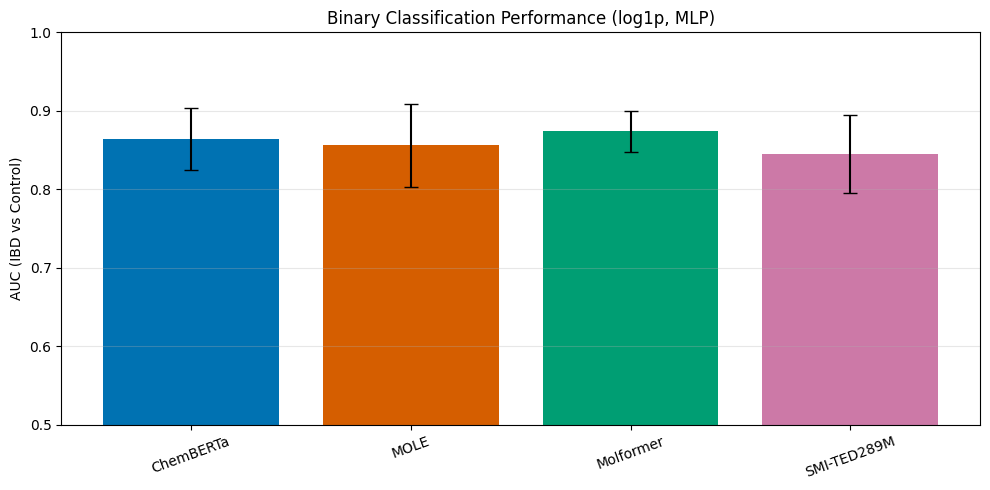

In [20]:
import matplotlib.pyplot as plt
import numpy as np

models = summary_table["model"].tolist()
auc_values = summary_table["binary_auc"].apply(lambda x: float(x.split("±")[0])).tolist()
auc_sd = summary_table["binary_auc"].apply(lambda x: float(x.split("±")[1])).tolist()

plt.figure(figsize=(10, 5))

for i, model in enumerate(models):
    plt.bar(
        i,
        auc_values[i],
        yerr=auc_sd[i],
        color=colors[model],
        capsize=5,
        label=model
    )

plt.xticks(range(len(models)), models, rotation=20)
plt.ylabel("AUC (IBD vs Control)")
plt.title("Binary Classification Performance (log1p, MLP)")
plt.ylim(0.5, 1.0)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


/opt/homebrew/lib/python3.13/site-packages/sklearn/utils/_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(
/opt/homebrew/lib/python3.13/site-packages/sklearn/utils/_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(
/opt/homebrew/lib/python3.13/site-packages/sklearn/utils/_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(
/opt/homebrew/lib/python3.13/site-packages/sklearn/utils/_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(


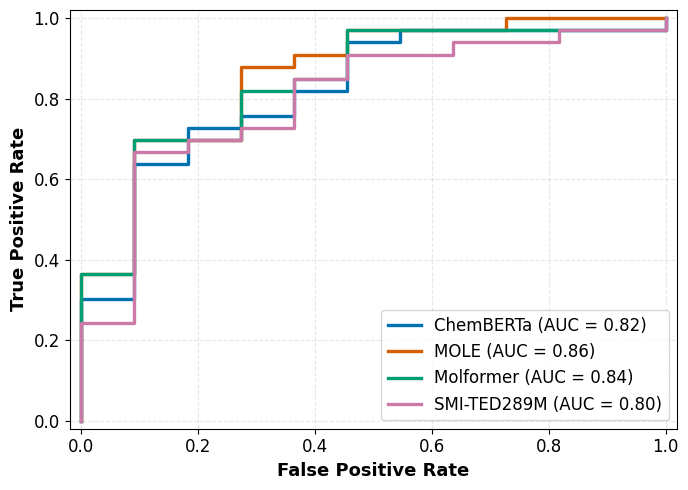

Saved: Figures/roc_curves_horizontal_mlp.png


In [26]:
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.close('all')  # optional: clear previous figures

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

fig, ax = plt.subplots(figsize=(7, 5))  # wide figure

for model_name in models:
    df = pd.read_parquet(base_dir / f"{model_name}_sample_embeddings_classification.parquet")
    X = df[[c for c in df.columns if c.startswith("emb_")]].to_numpy()
    y = np.array([1 if d in {"UC", "CD"} else 0 for d in df["Diagnosis"]])

    # first fold only (representative)
    train_idx, test_idx = next(cv.split(X, y))

    clf = MLPClassifier(
        hidden_layer_sizes=(64,),
        activation="relu",
        alpha=1e-3,
        max_iter=2000,
        random_state=0
    )
    clf.fit(X[train_idx], y[train_idx])

    RocCurveDisplay.from_estimator(
        clf,
        X[test_idx],
        y[test_idx],
        ax=ax,
        name=model_name,
        color=colors[model_name],
        linewidth=2.4,
    )

# formatting
#ax.set_title("ROC Curves (log1p transform, MLP)", fontsize=14, fontweight="bold", pad=12)
ax.set_xlabel("False Positive Rate", fontsize=13, fontweight="bold")
ax.set_ylabel("True Positive Rate", fontsize=13, fontweight="bold")
ax.tick_params(labelsize=12)
ax.grid(alpha=0.3, linestyle="--")
ax.set_xlim(-0.02, 1.02)
ax.set_ylim(-0.02, 1.02)

# force non-square axes so it actually looks horizontal
ax.set_aspect("auto")

ax.legend(fontsize=12, frameon=True, fancybox=True)

plt.tight_layout()
plt.savefig("Figures/roc_curves_horizontal_mlp.png", dpi=300, bbox_inches="tight")
plt.show()

print("Saved: Figures/roc_curves_horizontal_mlp.png")


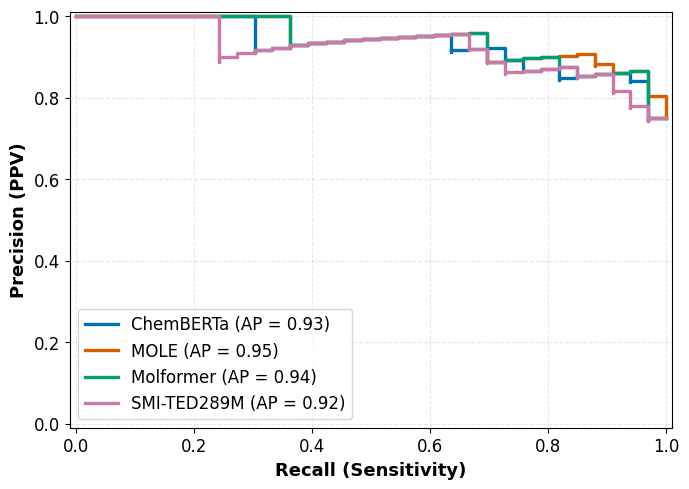

Saved: Figures/pr_curves_horizontal_mlp.png


In [27]:
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.close('all')

fig, ax = plt.subplots(figsize=(7, 5))  # horizontal figure

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

for model_name in models:
    df = pd.read_parquet(base_dir / f"{model_name}_sample_embeddings_classification.parquet")
    X = df[[c for c in df.columns if c.startswith("emb_")]].to_numpy()
    y = np.array([1 if d in {"UC","CD"} else 0 for d in df["Diagnosis"]])

    train_idx, test_idx = next(cv.split(X, y))

    clf = MLPClassifier(
        hidden_layer_sizes=(64,),
        activation="relu",
        alpha=1e-3,
        max_iter=2000,
        random_state=0
    )
    clf.fit(X[train_idx], y[train_idx])

    PrecisionRecallDisplay.from_estimator(
        clf,
        X[test_idx],
        y[test_idx],
        ax=ax,
        name=model_name,
        color=colors[model_name],
        linewidth=2.4,
    )

# Formatting for slides
#ax.set_title("Precision–Recall Curves (log1p, MLP)", fontsize=14, fontweight="bold", pad=12)
ax.set_xlabel("Recall (Sensitivity)", fontsize=13, fontweight="bold")
ax.set_ylabel("Precision (PPV)", fontsize=13, fontweight="bold")
ax.tick_params(labelsize=12)
ax.grid(alpha=0.3, linestyle="--")

# The crucial line to ensure landscape layout:
ax.set_aspect("auto")

# Legend
ax.legend(fontsize=12, frameon=True, fancybox=True)

plt.tight_layout()
plt.savefig("Figures/pr_curves_horizontal_mlp.png", dpi=300, bbox_inches="tight")
plt.show()

print("Saved: Figures/pr_curves_horizontal_mlp.png")


# include sensitivity and spec

In [28]:
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score
import numpy as np
import pandas as pd
from pathlib import Path

transform = "log1p"
models = ["ChemBERTa", "MOLE", "Molformer", "SMI-TED289M"]

base_dir = Path("Sample_level_embeddings") / transform
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# colors for plots
colors = {
    "ChemBERTa":   "#0072B2",
    "MOLE":        "#D55E00",
    "Molformer":   "#009E73",
    "SMI-TED289M": "#CC79A7",
}

results_emb = []

for model_name in models:
    print(f"\n=== log1p – Model: {model_name} ===")

    path = base_dir / f"{model_name}_sample_embeddings_classification.parquet"
    df = pd.read_parquet(path)

    # Embeddings
    emb_cols = [c for c in df.columns if c.startswith("emb_")]
    X = df[emb_cols].to_numpy(dtype=float)

    # Binary IBD vs Control
    y_diag = df["Diagnosis"].to_numpy()
    y_binary = np.array([1 if d in {"UC", "CD"} else 0 for d in y_diag], dtype=int)

    # Per-fold metrics
    fold_auc  = []
    fold_sens = []
    fold_spec = []

    for train_idx, test_idx in cv.split(X, y_binary):
        clf = MLPClassifier(
            hidden_layer_sizes=(64,),
            activation="relu",
            alpha=1e-3,
            max_iter=2000,
            random_state=0,
        )
        clf.fit(X[train_idx], y_binary[train_idx])

        y_pred  = clf.predict(X[test_idx])
        y_proba = clf.predict_proba(X[test_idx])[:, 1]

        # AUC
        fold_auc.append(roc_auc_score(y_binary[test_idx], y_proba))

        # confusion matrix with IBD=1 as positive
        cm = confusion_matrix(y_binary[test_idx], y_pred, labels=[1, 0])
        TP, FN = cm[0, 0], cm[0, 1]
        FP, TN = cm[1, 0], cm[1, 1]

        sens = TP / (TP + FN) if (TP + FN) > 0 else 0.0
        spec = TN / (TN + FP) if (TN + FP) > 0 else 0.0

        fold_sens.append(sens)
        fold_spec.append(spec)

    results_emb.append({
        "model": model_name,
        "auc_mean":  np.mean(fold_auc),
        "auc_std":   np.std(fold_auc),
        "sens_mean": np.mean(fold_sens),
        "sens_std":  np.std(fold_sens),
        "spec_mean": np.mean(fold_spec),
        "spec_std":  np.std(fold_spec),
        "n_samples": X.shape[0],
        "n_features": X.shape[1],
    })

metrics_df = pd.DataFrame(results_emb)
print("\n=== Binary metrics (IBD vs Control, log1p + MLP) ===")
print(metrics_df[["model", "auc_mean", "sens_mean", "spec_mean"]].round(3))



=== log1p – Model: ChemBERTa ===

=== log1p – Model: MOLE ===

=== log1p – Model: Molformer ===

=== log1p – Model: SMI-TED289M ===

=== Binary metrics (IBD vs Control, log1p + MLP) ===
         model  auc_mean  sens_mean  spec_mean
0    ChemBERTa     0.864      0.878      0.518
1         MOLE     0.856      0.884      0.644
2    Molformer     0.874      0.884      0.679
3  SMI-TED289M     0.845      0.920      0.305


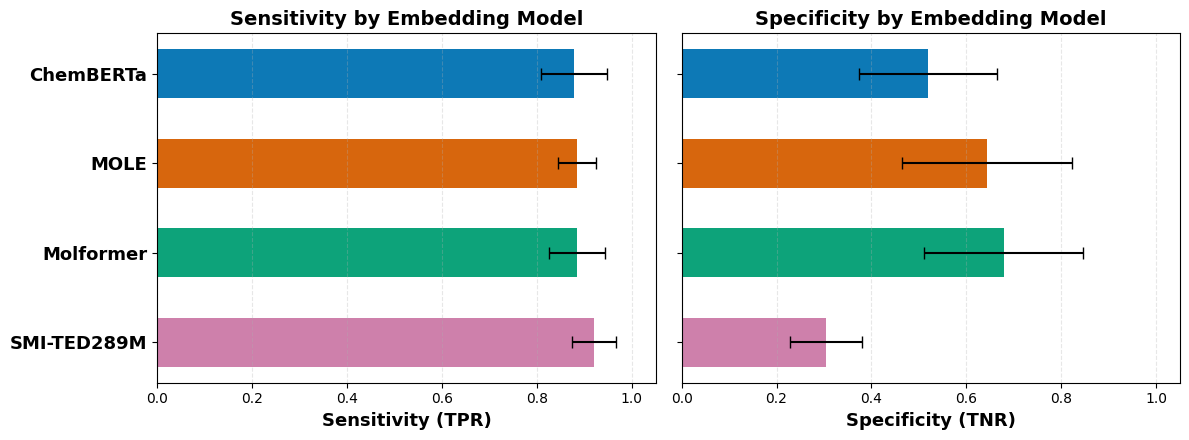

Saved: Figures/sens_spec_embeddings_mlp.png


In [29]:
import matplotlib.pyplot as plt
import numpy as np

models_order = metrics_df["model"].tolist()
y_pos = np.arange(len(models_order))

sens_means = metrics_df["sens_mean"].values
sens_stds  = metrics_df["sens_std"].values
spec_means = metrics_df["spec_mean"].values
spec_stds  = metrics_df["spec_std"].values

fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))

# ---- Sensitivity ----
ax = axes[0]
for i, m in enumerate(models_order):
    ax.barh(
        y_pos[i],
        sens_means[i],
        xerr=sens_stds[i],
        color=colors[m],
        alpha=0.95,
        ecolor="black",
        capsize=4,
        height=0.55,
    )

ax.set_yticks(y_pos)
ax.set_yticklabels(models_order, fontsize=13, fontweight="bold")
ax.invert_yaxis()
ax.set_xlabel("Sensitivity (TPR)", fontsize=13, fontweight="bold")
ax.set_xlim(0, 1.05)
ax.set_title("Sensitivity by Embedding Model", fontsize=14, fontweight="bold")
ax.grid(axis="x", alpha=0.3, linestyle="--")

# ---- Specificity ----
ax = axes[1]
for i, m in enumerate(models_order):
    ax.barh(
        y_pos[i],
        spec_means[i],
        xerr=spec_stds[i],
        color=colors[m],
        alpha=0.95,
        ecolor="black",
        capsize=4,
        height=0.55,
    )

ax.set_yticks(y_pos)
ax.set_yticklabels([])  # labels only on left plot
ax.invert_yaxis()
ax.set_xlabel("Specificity (TNR)", fontsize=13, fontweight="bold")
ax.set_xlim(0, 1.05)
ax.set_title("Specificity by Embedding Model", fontsize=14, fontweight="bold")
ax.grid(axis="x", alpha=0.3, linestyle="--")

plt.tight_layout()
plt.savefig("Figures/sens_spec_embeddings_mlp.png", dpi=300, bbox_inches="tight")
plt.show()

print("Saved: Figures/sens_spec_embeddings_mlp.png")


### correct ROC curves using CV across all curves

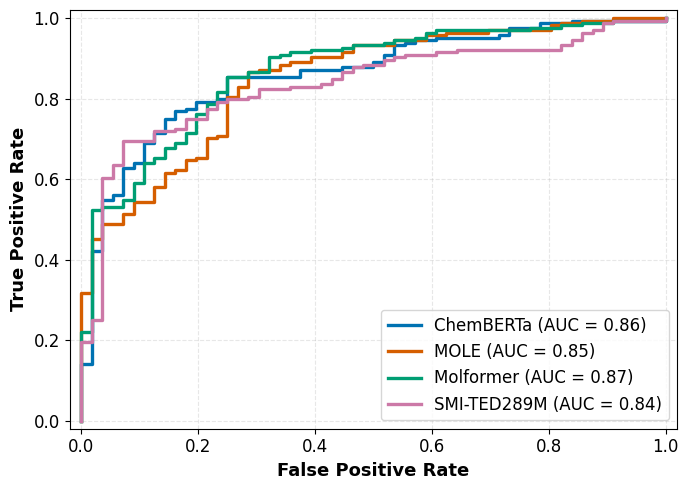

Saved: Figures/roc_curves_horizontal_mlp_cv.png


In [30]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.close('all')

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

fig, ax = plt.subplots(figsize=(7, 5))

for model_name in models:
    df = pd.read_parquet(base_dir / f"{model_name}_sample_embeddings_classification.parquet")
    X = df[[c for c in df.columns if c.startswith("emb_")]].to_numpy()
    y = np.array([1 if d in {"UC", "CD"} else 0 for d in df["Diagnosis"]])

    # out-of-fold probabilities container
    y_true_all = []
    y_proba_all = []

    for train_idx, test_idx in cv.split(X, y):
        clf = MLPClassifier(
            hidden_layer_sizes=(64,),
            activation="relu",
            alpha=1e-3,
            max_iter=2000,
            random_state=0
        )
        clf.fit(X[train_idx], y[train_idx])
        proba = clf.predict_proba(X[test_idx])[:, 1]

        y_true_all.append(y[test_idx])
        y_proba_all.append(proba)

    y_true_all = np.concatenate(y_true_all)
    y_proba_all = np.concatenate(y_proba_all)

    fpr, tpr, _ = roc_curve(y_true_all, y_proba_all)
    auc_val = roc_auc_score(y_true_all, y_proba_all)

    ax.plot(
        fpr,
        tpr,
        label=f"{model_name} (AUC = {auc_val:.2f})",
        color=colors[model_name],
        linewidth=2.4,
    )

# formatting
ax.set_xlabel("False Positive Rate", fontsize=13, fontweight="bold")
ax.set_ylabel("True Positive Rate", fontsize=13, fontweight="bold")
ax.tick_params(labelsize=12)
ax.grid(alpha=0.3, linestyle="--")
ax.set_xlim(-0.02, 1.02)
ax.set_ylim(-0.02, 1.02)
ax.set_aspect("auto")

ax.legend(fontsize=12, frameon=True, fancybox=True)

plt.tight_layout()
plt.savefig("Figures/roc_curves_horizontal_mlp_cv.png", dpi=300, bbox_inches="tight")
plt.show()

print("Saved: Figures/roc_curves_horizontal_mlp_cv.png")


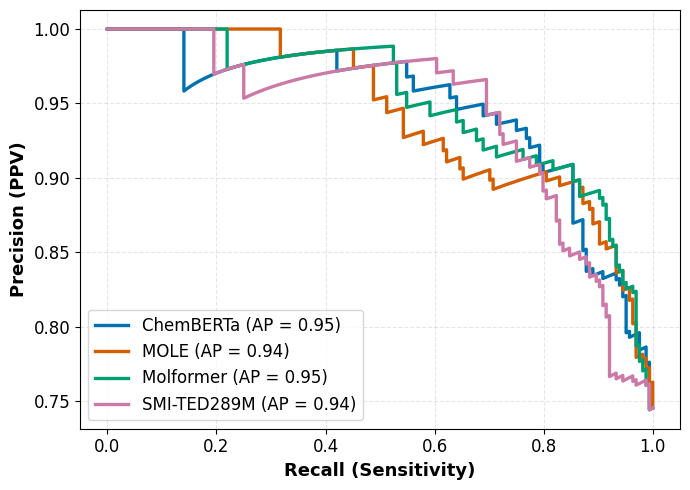

Saved: Figures/pr_curves_horizontal_mlp_cv.png


In [31]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.close('all')

fig, ax = plt.subplots(figsize=(7, 5))  # horizontal figure

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

for model_name in models:
    df = pd.read_parquet(base_dir / f"{model_name}_sample_embeddings_classification.parquet")
    X = df[[c for c in df.columns if c.startswith("emb_")]].to_numpy()
    y = np.array([1 if d in {"UC","CD"} else 0 for d in df["Diagnosis"]])

    # Collect out-of-fold predictions
    y_true_all = []
    y_proba_all = []

    for train_idx, test_idx in cv.split(X, y):
        clf = MLPClassifier(
            hidden_layer_sizes=(64,),
            activation="relu",
            alpha=1e-3,
            max_iter=2000,
            random_state=0
        )
        clf.fit(X[train_idx], y[train_idx])

        proba = clf.predict_proba(X[test_idx])[:, 1]

        y_true_all.append(y[test_idx])
        y_proba_all.append(proba)

    y_true_all = np.concatenate(y_true_all)
    y_proba_all = np.concatenate(y_proba_all)

    precision, recall, _ = precision_recall_curve(y_true_all, y_proba_all)
    ap = average_precision_score(y_true_all, y_proba_all)

    ax.plot(
        recall,
        precision,
        label=f"{model_name} (AP = {ap:.2f})",
        color=colors[model_name],
        linewidth=2.4,
    )

# Formatting for slides
ax.set_xlabel("Recall (Sensitivity)", fontsize=13, fontweight="bold")
ax.set_ylabel("Precision (PPV)", fontsize=13, fontweight="bold")
ax.tick_params(labelsize=12)
ax.grid(alpha=0.3, linestyle="--")
ax.set_aspect("auto")

# Legend
ax.legend(fontsize=12, frameon=True, fancybox=True)

plt.tight_layout()
plt.savefig("Figures/pr_curves_horizontal_mlp_cv.png", dpi=300, bbox_inches="tight")
plt.show()

print("Saved: Figures/pr_curves_horizontal_mlp_cv.png")
